## In this notebook

- Create a no-memory base model.
- Overall goal of the task: Predict electronic vehicles charging stations availability in Paris.
- There are four target columns:
    - `Available`: how many plugs are available at time t for the station k,
    - `Charging`: how many plugs are occupied and charging at time t for the station k,
    - `Passive`: how many plugs are occupied but not charging at time t for the station k,
    - `Other`: how many plugs are either offline or out of order at time t for the station k.

In [1]:
import os

# analytics
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import numpy as np

# model
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    f1_score, 
    precision_score, 
    recall_score, 
    top_k_accuracy_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

# plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
DATA_FOLDER = "../data"

DAYS_IN_TEST_SET = 7 * 4

Y_COLUMN = "available"
X_COLUMNS = [
    "tod",
    "dow",
    "latitude",
    "longitude",
    "postcode",
    "area",
]

In [4]:
! ls -l $DATA_FOLDER

total 181500
-rw-rw-r-- 1 nobody nogroup  14095077 Aug  4 08:41 test.csv
-rw-rw-r-- 1 nobody nogroup 171754453 Aug  4 08:41 train.csv


## Load data

In [5]:
# load train data

df = pd.read_csv(os.path.join(DATA_FOLDER, "train.csv"))
df.columns = [col.lower() for col in df.columns]

df.tail()

,date,station,available,charging,passive,other,tod,dow,trend,latitude,longitude,postcode,area
1851078,2021-02-18 23:45:00,FR*V75*EBELI*95*1,0,0,0,3,95,5,22202,48.86851,2.295469,75016,west
1851079,2021-02-18 23:45:00,FR*V75*EBELI*96*1,2,1,0,0,95,5,22202,48.83550,2.349650,75013,south
1851080,2021-02-18 23:45:00,FR*V75*EBELI*97*1,1,1,1,0,95,5,22202,48.83995,2.397822,75012,east
1851081,2021-02-18 23:45:00,FR*V75*EBELI*98*1,2,0,1,0,95,5,22202,48.84998,2.361920,75004,south
1851082,2021-02-18 23:45:00,FR*V75*EBELI*99*1,3,0,0,0,95,5,22202,48.87780,2.391820,75019,east


In [6]:
# leave only one target - "available" - in the data set

df = df.drop(["charging", "passive", "other"], axis=1)

## Process data

In [7]:
# split data into X and y

df["date"] = pd.to_datetime(df.date)
df = df.sort_values(by=["date"]).reset_index(drop=True)

last_train_set_datetime = df.date.max() - pd.Timedelta(days=DAYS_IN_TEST_SET)

X_train = df.loc[df.date <= last_train_set_datetime, X_COLUMNS]
y_train = df.loc[df.date <= last_train_set_datetime, Y_COLUMN]
X_test = df.loc[df.date > last_train_set_datetime, X_COLUMNS]
y_test = df.loc[df.date > last_train_set_datetime, Y_COLUMN]


print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_test.shape=}")
print(f"{y_test.shape=}")

X_train.shape=(1633778, 6)
y_train.shape=(1633778,)
X_test.shape=(217305, 6)
y_test.shape=(217305,)


## Build model

In [8]:
# define categorical transformers

cols_categorical = [
    "postcode",
    "area",
]

transformers_categorical = Pipeline(
    steps=[
        # ("ordinal_encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=999))
        ("ordinal_encoder", OrdinalEncoder())
    ]
)

In [9]:
# define coordinates transformers

cols_coordinates = [
    "latitude",
    "longitude",
]

transformers_coordinates = Pipeline(
    steps=[
        ("min_max_scaler", MinMaxScaler())
    ]
)

In [10]:
%%time

# define and fit pipeline

transformers = ColumnTransformer(
    transformers=[
        ("categorical", transformers_categorical, cols_categorical),
        ("coordinates", transformers_coordinates, cols_coordinates),
    ],
    remainder="passthrough"
)

pipeline = Pipeline([
    ("transformers", transformers),
    ("model", GradientBoostingClassifier())
])

pipeline.fit(X_train, y_train)

CPU times: user 5min 49s, sys: 3.73 s, total: 5min 53s
Wall time: 5min 53s


Pipeline(steps=[('transformers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['postcode', 'area']),
                                                 ('coordinates',
                                                  Pipeline(steps=[('min_max_scaler',
                                                                   MinMaxScaler())]),
                                                  ['latitude', 'longitude'])])),
                ('model', GradientBoostingClassifier())])

In [11]:
# check performance on test dataset

y_test_pred = pipeline.predict(X_test)
y_test_pred_probas = pipeline.predict_proba(X_test)

print("Results:")
print(f"- accuracy: {accuracy_score(y_test, y_test_pred):,.3f}")
print(f"- precision: {precision_score(y_test, y_test_pred, average='weighted', zero_division=0):,.3f}")
print(f"- recall: {recall_score(y_test, y_test_pred, average='weighted'):,.3f}")
print(f"- F1: {f1_score(y_test, y_test_pred, average='weighted'):,.3f}")
print(f"- accuracy (top k=2): {top_k_accuracy_score(y_test, y_test_pred_probas, k=2):,.3f}")
print()
print(f"- confusion matrix: \n{confusion_matrix(y_test, y_test_pred)}")

Results:
- accuracy: 0.416
- precision: 0.408
- recall: 0.416
- F1: 0.370
- accuracy (top k=2): 0.719

- confusion matrix: 
[[20202   377 14978 20863]
 [ 4206  1421 11513 14366]
 [ 5180  1746 13180 40782]
 [ 6188   762  6025 55516]]


<AxesSubplot: >

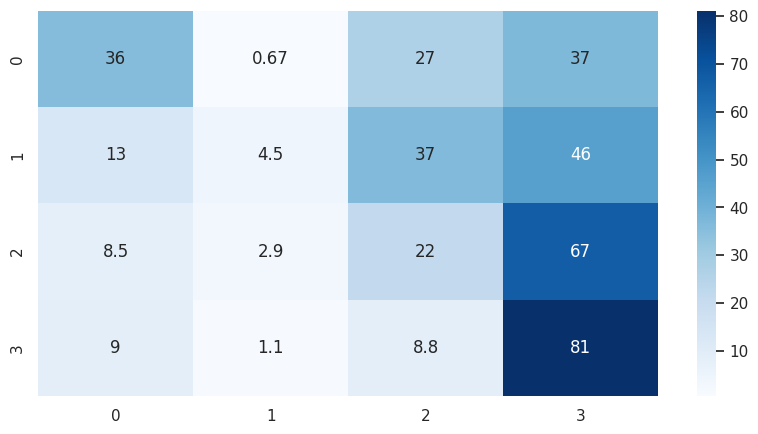

In [12]:
# check confusion matrix (with shares in every true class=rows)

cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(
    cm / cm.sum(axis=1).reshape(-1, 1) * 100, 
    annot=True,
    # fmt='g',
    cmap='Blues',
)

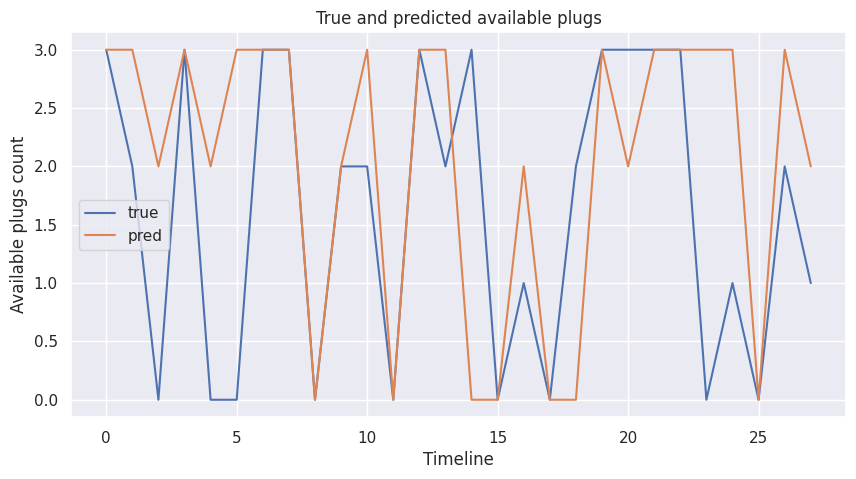

In [14]:
# check comparison of true and predicted available plugs

df_results = pd.DataFrame({
    "true": y_test.values,
    "pred": y_test_pred,
})

# ax = df_results.plot(alpha=0.75)
ax = df_results.head(DAYS_IN_TEST_SET).plot()

ax.set_xlabel("Timeline")
ax.set_ylabel("Available plugs count")
ax.set_title("True and predicted available plugs, random station")

plt.show()

## Results

- Created a no-memory base model.
- The results are following:
    - accuracy: 0.416
    - precision: 0.408
    - recall: 0.416
    - F1: 0.370
    - accuracy (top k=2): 0.719